### Install/Update Packages

If the CUDA toolkit version is less than 10.1, be sure to install the CUDA 10.1 or 10.2.

In [1]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:07:16_PDT_2019
Cuda compilation tools, release 10.1, V10.1.243


In [2]:
import sys, subprocess
subprocess.call([sys.executable, '-m', 'pip', 'install', 'gluonnlp', 'torch', 'sentencepiece', 'tqdm', 
                 'onnxruntime', 'transformers', 'git+https://git@github.com/SKTBrain/KoBERT.git@master'])

0

In [3]:
import io, os
import random
import pandas as pd
import numpy as np
import mxnet as mx
from mxnet.gluon import nn, rnn
from mxnet import nd, gluon, autograd
import gluonnlp as nlp
import time
import itertools
import random
import sys

sys.path.append(os.path.join(os.getcwd(), 'src'))

from model import get_mxnet_kobert_model
from kobert.utils import get_tokenizer
from bert import BERTDatasetTransform, BERTDataset, BERTClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

I assume you have at least one GPU. Of course, GPU is not required when deploying a trained model, but it is very slow without a GPU for training.

In [5]:
wk_folder = os.getcwd()
#num_gpus = mx.context.num_gpus()
num_gpus = 2
ctx = [mx.gpu(i) for i in range(num_gpus)]
print("Working Folder: ", wk_folder)
print("Number of GPUS:" , num_gpus)

Working Folder:  /home/ec2-user/SageMaker/sentence-similarity-workshop/scratch/sentBert
Number of GPUS: 2


### Get pre-trained KoBERT model

In [6]:
bert_base, vocab = get_mxnet_kobert_model(use_decoder=False, use_classifier=False, ctx=ctx)

using cached model
using cached model


### Initialize BERT Classifier
We only need one addiational `Dense` layer for classification task.
GluonNLP's `model` class supports the `BERTClassifier()`, so you can easily add the classifier layer in one line. Of course, you can implement your own class. See `src/bert.py` for details.

In [7]:
bert_classifier = nlp.model.BERTClassifier(bert_base, num_classes=2, 
                                           dropout=0.5)


# Only need to initialize the classifier layer.
bert_classifier.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
bert_classifier.hybridize(static_alloc=True)

# softmax cross entropy loss for classification
loss_function = gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

metric = mx.metric.Accuracy()

In [8]:
# print(bert_classifier)

<br>

## 2. Preparing the Dataset
---


In [9]:
df = pd.read_csv('preproc/train/train.tab', sep='\t')
df.head()

,genre,filename,year,id,score,sentence1,sentence2,label
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.,1
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.,1
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.,1
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.,0
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.,1


In [10]:
df = pd.read_csv('preproc/test/test.tab', sep='\t')
df.head(10)

,genre,filename,year,id,score,sentence1,sentence2,label
0,main-captions,MSRvid,2012test,24,2.500,한 소녀가 머리를 스타일링하고 있다.,한 소녀가 머리를 빗고 있다.,0
1,main-captions,MSRvid,2012test,33,3.600,한 무리의 남자들이 해변에서 축구를 한다.,한 무리의 소년들이 해변에서 축구를 하고 있다.,1
2,main-captions,MSRvid,2012test,45,5.000,한 여성이 다른 여성의 발목을 재고 있다.,한 여자는 다른 여자의 발목을 측정한다.,1
3,main-captions,MSRvid,2012test,63,4.200,한 남자가 오이를 자르고 있다.,한 남자가 오이를 자르고 있다.,1
4,main-captions,MSRvid,2012test,66,1.500,한 남자가 하프를 연주하고 있다.,한 남자가 키보드를 연주하고 있다.,0
5,main-captions,MSRvid,2012test,74,1.800,한 여자가 양파를 자르고 있다.,한 여자가 두부를 자르고 있다.,0
6,main-captions,MSRvid,2012test,76,3.500,한 남자가 전기 자전거를 타고 있다.,한 남자가 자전거를 타고 있다.,1
7,main-captions,MSRvid,2012test,82,2.200,한 남자가 드럼을 치고 있다.,남자가 기타를 치고 있다.,0
8,main-captions,MSRvid,2012test,92,2.200,한 남자가 기타를 치고 있다.,한 여성이 기타를 연주하고 있다.,0
9,main-captions,MSRvid,2012test,95,1.714,한 남자가 기타를 치고 있다.,한 남자가 트럼펫을 연주하고 있다.,0


In [11]:
dataset_train = nlp.data.TSVDataset('preproc/train/train.tab', 
                                     field_indices=[5,6,7], 
                                     num_discard_samples=1)

dataset_test = nlp.data.TSVDataset('preproc/test/test.tab', 
                                     field_indices=[5,6,7], 
                                     num_discard_samples=1)


print(dataset_train[0])
print(dataset_test[10])

['비행기가 이륙하고 있다.', '비행기가 이륙하고 있다.', '1']
['한 남자가 기타를 치고 있다.', '한 남자가 트럼펫을 연주하고 있다.', '0']


<br>

## 3. Tokenization & Transform
---
Transform the dataset into the format that BERT can be trained on. 

### Get tokenizer

In [12]:
tokenizer = get_tokenizer()
bert_tokenizer = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

using cached model


### Transformation

Input sentences must be converted to token index, token type, and valid length, which are necessary input vectors for BERT training. Token index is required to generate Token Embedding, token type is required for Sentence Embedding, and valid length is required to perform various operations internally. 

- ***Token Index***: The vocabulary index of each token is extracted and generated as a vector of a fixed length. We often refer to these vectors as `token_id`.
For reference, some vocabulary indexes are already reserved (e.g., The vocabulary indexes of `[PAD], [CLS], [SEP], [MASK]` are 1, 2, 3, 4, respectively).
- ***Token Type***: Since single sentence or two sentences can come in, token segment vectors are required to distinguish them if a token belongs to first sentence or the second sentence. We often refer to these vectors as `segment_id`. 
    - In the case of single sentence, the value of each token is always 0.
    - In the case of two sentences, the token belonging to the first sentence is 0, and the token belonging to the second sentence is 1.


In [13]:
print('vocabulary used for tokenization = \n%s'%vocab)
print('%s token id = %s'%(vocab.padding_token, vocab[vocab.padding_token]))
print('%s token id = %s'%(vocab.cls_token, vocab[vocab.cls_token]))
print('%s token id = %s'%(vocab.sep_token, vocab[vocab.sep_token]))
print('%s token id = %s'%(vocab.mask_token, vocab[vocab.mask_token]))

vocabulary used for tokenization = 
Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
[MASK] token id = 4


Transformation is performed through the following procedures.

- Tokenize the input sequences 
- Insert `[CLS]` token at the beginning 
- Insert `[SEP]` token between sentence A and sentence B, and at the end 
- Generate segment ids to indicate whether a token belongs to the first sequence or the second sequence. If the input sentence is not a pair, this value is always 0.
- Generate valid length.

Let's transform one sentence for test purpose.

Let's convert all sententces. When converting multiple sentences, it is convenient to use the `BERTDatasetTransform()` function, which is published in the GluonNLP tutorial. The training and evaluation time varies depending on the `max_len` parameter. In this example, we recommend 64.

Let's check sample outputs.

In [14]:
from bert2 import data
vocabulary = vocab
def print_sample_transform2(dataset, idx, bert_tokenizer, max_seq_length=20, pair=True):
    label = [[dataset[idx][0]]]
    sen1 = dataset[idx][1]
    sen2 = dataset[idx][2]    
    
    # The labels for the two classes [(0 = not similar) or  (1 = similar)]
    all_labels = ["0", "1"]

    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    # for regression task, set class_labels=None
    # for inference without label available, set has_label=False
    pair = True
    transform = data.transform.BERTDatasetTransform(bert_tokenizer, max_seq_length,
                                                    class_labels=all_labels,
                                                    has_label=True,
                                                    pad=True,
                                                    pair=pair)

    

    data_train = dataset.transform(transform)
    print(data_train)

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('%s token id = %s'%(vocabulary.padding_token, vocabulary[vocabulary.padding_token]))
    print('%s token id = %s'%(vocabulary.cls_token, vocabulary[vocabulary.cls_token]))
    print('%s token id = %s'%(vocabulary.sep_token, vocabulary[vocabulary.sep_token]))
    print('token ids = \n%s'%data_train[idx][0])
    print('segment ids = \n%s'%data_train[idx][1])
    print('valid length = \n%s'%data_train[idx][2])
    print('label = \n%s'%data_train[idx][3])    
    return data_train
    
data_train = print_sample_transform2(dataset_train, 0, bert_tokenizer, max_seq_length=100)
data_test = print_sample_transform2(dataset_test, 0, bert_tokenizer, max_seq_length = 100)
# data_train[0]

vocabulary used for tokenization = 
Vocab(size=8002, unk="[UNK]", reserved="['[CLS]', '[SEP]', '[MASK]', '[PAD]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[   2 2545 5330 3647 6108 7788 3862  517   54    3 2545 5330 3647 6108
 7788 3862  517   54    3    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
segment ids = 
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
valid length = 
19
label = 
[1]
vocabulary used for tokenization = 
Vocab(size=8002, u

In [15]:
sample_id = 0
print('token ids = \n%s'%data_train[sample_id][0])
print('segment ids = \n%s'%data_train[sample_id][1])
print('valid length = \n%s'%data_train[sample_id][2])
print('label = \n%s'%data_train[sample_id][3])

token ids = 
[   2 2545 5330 3647 6108 7788 3862  517   54    3 2545 5330 3647 6108
 7788 3862  517   54    3    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1    1    1    1    1    1    1    1    1    1    1    1    1
    1    1]
segment ids = 
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
valid length = 
19
label = 
[1]


<br>

## 4. Creating DataLoader and Trainer 
---
We need to create an iterator for tha dataset using `DataLoader`. Iterators save memory during training because you don not have to load the entire dataset into memory.

### Setting hyperparameters

You can specify only 1 for `num_epoch`. This dataset is close to 90% accuracy when fine-tuning with KoBERT, but training only 1 epoch yields 88% accuracy.

In [16]:
batch_size = 64 * num_gpus
num_epochs = 6
max_grad_norm = 1
log_interval = 50
lr = 5e-5

In [17]:
%%time
# The FixedBucketSampler and the DataLoader for making the mini-batches
train_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_train],
                                            batch_size=batch_size,
                                            shuffle=True)
train_dataloader = gluon.data.DataLoader(data_train, batch_sampler=train_sampler)

CPU times: user 1.17 s, sys: 0 ns, total: 1.17 s
Wall time: 1.17 s


In [18]:
%%time
test_sampler = nlp.data.FixedBucketSampler(lengths=[int(item[2]) for item in data_test],
                                            batch_size=batch_size,
                                            shuffle=True)
test_dataloader = mx.gluon.data.DataLoader(data_test, batch_sampler=test_sampler)

CPU times: user 283 ms, sys: 0 ns, total: 283 ms
Wall time: 282 ms


Initialize the `gluon.Trainer()`. Gradient clipping to prevent the exploding gradient can be implemented during training, but can be used simply by specifying it when initializing the `gluon.Trainer()`.

In [19]:
all_model_params = bert_classifier.collect_params()
trainer = gluon.Trainer(all_model_params, 'adam',
                        {'learning_rate': lr, 'epsilon': 1e-9, 'clip_gradient': 1}, 
                        kvstore='device')
    
# Weight Decay is not applied to LayerNorm and Bias.
for _, v in bert_classifier.collect_params('.*beta|.*gamma|.*bias').items():
    v.wd_mult = 0.0
    
# Collect all differentiable parameters
# `grad_req == 'null'` indicates no gradients are calculated (e.g. constant parameters)
# The gradients for these params are clipped later
params = [p for p in all_model_params.values() if p.grad_req != 'null']  

<br>

## 5. Fine-tuning the model
---
Now you can start fine-tuning the model with a few epochs. The code below is based on the [GluonNLP tutorial](https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html) and the [BERT Fine-tuning](https://mccormickml.com/2019/07/22/BERT-fine-tuning/). <br>
On a single GPU basis, 1 epoch training takes about 9 minutes on `p3.2xlarge` instance, and 1 epoch training takes about 25 minutes on `g4dn.xlarge` instance. Using multi-GPU greatly reduces the training time, and it takes about 4 minutes 30 seconds to train 1 epoch using `p3.8xlarge` instance.

In [20]:
import time
import datetime
# import tqdm
# from tqdm.notebook import tqdm

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def evaluate_accuracy(model, data_iter, ctx):
    acc = mx.metric.Accuracy()
    total_loss = 0
    
    for batch_id, (token_ids, segment_ids, valid_length, label) in enumerate(data_iter):
        
        token_ids = token_ids.as_in_context(ctx)
        valid_length = valid_length.as_in_context(ctx)
        segment_ids = segment_ids.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        out = model(token_ids, segment_ids, valid_length.astype('float32'))
        ls = loss_function(out, label).mean()
        total_loss += ls.asscalar()
        
        acc.update(preds=out, labels=label)
        
    avg_acc = acc.get()[1]
    avg_loss = total_loss / batch_id
    
    print('Validation loss={:.4f}, acc={:.3f}'.format(avg_loss, avg_acc))
    total_loss = 0

    return avg_acc, avg_loss  

In [21]:
%%time
import os
output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
print("Saving model to %s" % output_dir)

training_stats = []
step_num = 0

# Measure the total training time for the whole run.
total_t0 = time.time()

for epoch_id in range(num_epochs):

    # === Training phase ===
    
    # Measure how long the training epoch takes.
    t0 = time.time()    
    
    metric.reset()
    step_loss = 0
    total_loss = 0
    
    for batch_id, (token_ids, segment_ids, valid_length, label) in enumerate(train_dataloader):
        
        # Load the data to the GPUs
        token_ids_ = gluon.utils.split_and_load(token_ids, ctx, even_split=False)
        valid_length_ = gluon.utils.split_and_load(valid_length, ctx, even_split=False)
        segment_ids_ = gluon.utils.split_and_load(segment_ids, ctx, even_split=False)
        label_ = gluon.utils.split_and_load(label, ctx, even_split=False)

        losses = []
        with autograd.record():

            for t, v, s, l in zip(token_ids_, valid_length_, segment_ids_, label_):
                # Forward computation
                out = bert_classifier(t, s, v.astype('float32'))
                ls = loss_function(out, l)
                losses.append(ls)
                metric.update([l], [out])

        # Perform a backward pass to calculate the gradients        
        for ls in losses:
            ls.backward()  
        
        trainer.step(batch_size)
        
        # Sum losses over all devices
        sum_loss = (sum([l.sum().asscalar() for l in losses]))/batch_size
        step_loss += sum_loss
        total_loss += sum_loss
        #metric.update([label], [out])

        # Printing vital information
        if (batch_id + 1) % (log_interval) == 0:
            print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}'
                         .format(epoch_id, batch_id + 1, len(train_dataloader),
                                 step_loss / log_interval,
                                 trainer.learning_rate, metric.get()[1]))
            step_loss = 0
            
        train_avg_acc = metric.get()[1]
        train_avg_loss = total_loss
        total_loss = 0

    
    # Measure how long this epoch took.
    train_time = format_time(time.time() - t0)
    
    # === Validation phase ===
    
    # Measure how long the validation epoch takes.    
    t0 = time.time()    
    valid_avg_acc, valid_avg_loss = evaluate_accuracy(bert_classifier, test_dataloader, ctx[0])

    # Measure how long this epoch took.
    valid_time = format_time(time.time() - t0)
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
     # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_id + 1,
            'train_acc': train_avg_acc,
            'train_loss': train_avg_loss,
            'train_time': train_time,
            'valid_acc': valid_avg_acc,
            'valid_loss': valid_avg_loss,
            'valid_time': valid_time
        }
    )    
    
    # === Save Model Parameters ===
    bert_classifier.save_parameters('{}/net_epoch{}.params'.format(output_dir, epoch_id))    

Saving model to ./model_save/
Validation loss=0.5079, acc=0.749
Validation loss=0.6907, acc=0.565
Validation loss=0.4919, acc=0.789
Validation loss=0.4930, acc=0.807
Validation loss=0.4932, acc=0.809
Validation loss=0.6072, acc=0.810
Validation loss=0.7107, acc=0.805
Validation loss=0.7290, acc=0.798
Validation loss=0.7258, acc=0.798
Validation loss=0.8138, acc=0.802
CPU times: user 5min 29s, sys: 2min 25s, total: 7min 54s
Wall time: 3min 50s


<br>

## 6. Evaluation
---

Let's take a brief look at the training results so far.
Having a lot of epochs is not a good thing. As you can see in the graph and table, training metrics continue to decrease, but validation metrics decrease after some point.

The validation accuracy is pretty good with 89%, which is slightly less than the 90.1% accuracy on the official site, but has not been hyperparameter tuned.

In [22]:
import pandas as pd
pd.set_option('precision', 4)

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')

df_stats

,train_acc,train_loss,train_time,valid_acc,valid_loss,valid_time
epoch,,,,,,
1,0.6619,0.5771,0:00:21,0.7485,0.5079,0:00:02
2,0.7814,0.7173,0:00:20,0.5647,0.6907,0:00:02
3,0.7653,0.2816,0:00:20,0.7892,0.4919,0:00:02
4,0.8915,0.2784,0:00:20,0.8067,0.4930,0:00:02
5,0.9448,0.2290,0:00:20,0.8089,0.4932,0:00:03
6,0.9664,0.0299,0:00:20,0.8096,0.6072,0:00:03
7,0.9766,0.0088,0:00:20,0.8052,0.7107,0:00:03
8,0.9808,0.0713,0:00:20,0.7980,0.7290,0:00:03
9,0.9643,0.1530,0:00:20,0.7980,0.7258,0:00:03


In [23]:
def plot_training_stats(df_stats, num_epochs=5):
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.2)
    plt.rcParams["figure.figsize"] = (15,6)

    xticks = list(range(1, num_epochs+1))

    plt.subplot(221)

    ax1 = plt.subplot(1, 2, 1)
    ax1.plot(df_stats['train_loss'], 'b-o', label="Training")
    ax1.plot(df_stats['valid_loss'], 'g-o', label="Validation")
    ax1.set_xticks(xticks)     
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.legend()

    ax2 = plt.subplot(1, 2, 2)
    ax2.plot(df_stats['train_acc'], 'b-o', label="Training")
    ax2.plot(df_stats['valid_acc'], 'g-o', label="Validation")
    ax2.set_xticks(xticks) 
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.legend()

    plt.show()    

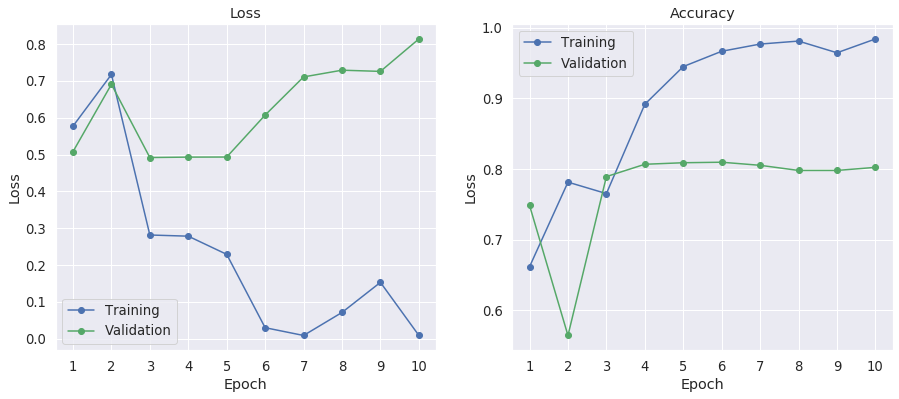

In [24]:
%matplotlib inline
plot_training_stats(df_stats, num_epochs)

Delete all but the best performing models.

In [25]:
idx = df_stats['valid_acc'].argmax() - 1
save_filename = 'net_epoch{}.params'.format(idx)

for filename in os.listdir(output_dir):
    if filename.endswith('params'):
        if filename == save_filename:
            os.rename(os.path.join(output_dir, filename), os.path.join(output_dir, 'net_nsmc.params'))
        else:
            os.remove(os.path.join(output_dir, filename))

If you want to deploy the fine-tuned model to the SageMaker Endpoint, please copy the `.spiece` file to the model parameter folder and compress them with `model.tar.gz`.

```bash
# Example shell scripts
$ cp ~/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece ./model_save/.
$ cd model_save
$ tar cvfz model.tar.gz ./*.params ./*.spiece
$ aws s3 cp ./model.tar.gz s3://<your-bucket-name>/kobert-model/model.tar.gz
```

In [26]:
if '/root/' in wk_folder:
    os.system("cp /root/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece ./model_save/.")
else:
    root_path = '~/'
    os.system("cp ~/kobert/kobert_news_wiki_ko_cased-1087f8699e.spiece ./model_save/.")

In [27]:
!tar cvfz ./model_save/model.tar.gz ./model_save/*.params ./model_save/*.spiece

./model_save/net_nsmc.params
./model_save/kobert_news_wiki_ko_cased-1087f8699e.spiece


## References

[1] Devlin, Jacob, et al. "Bert: Pre-training of deep bidirectional transformers for language understanding."
arXiv preprint arXiv:1810.04805 (2018).

[2] Dolan, William B., and Chris Brockett. "Automatically constructing a corpus of sentential paraphrases." Proceedings of the Third International Workshop on Paraphrasing (IWP2005). 2005.

[3] Peters, Matthew E., et al. "Deep contextualized word representations." arXiv preprint arXiv:1802.05365 (2018).

[4] GluonNLP Tutorial. Fine-tuning Sentence Pair Classification with BERT, <https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html>.

[5] Chris McCormick. BERT Fine-Tuning Tutorial with PyTorch, <https://mccormickml.com/2019/07/22/BERT-fine-tuning>.

[6] Jay Alammar. A Visual Guide to Using BERT for the First Time, <http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time>